![](https://i.pinimg.com/originals/76/6b/2f/766b2f93981d547dff24d8388939213d.png)

This kernel will give you an overview of the evolution of Deep Convolution Neural Network architectures and also the tweak to solve **image classification problem**.

Well we are so familiar with this name but have it ever occured to you that why not use a **Artificial Neural Network(ANN)**. Why to use CNN at the first place.?

Because if you would use Fully connected ANN then you would have to train a lot of parameters and network has to optimize all of these parameters, the training process could then become very time and storage intensive. In order to solve this computational problem, a different kind of network architecture is used, called **Convolutional Neural Network (CNN)**

CNNs **introduce two new types of hidden layers** in which each neuron is only connected to a small subset of the neurons in the previous layer, to prevent the aforementioned problem.

*  **Convolutional Layer** : What separates a convolutional layer from a fully-connected one is that each neuron is only connected to a small, local subset of the neurons in the previous layer, which is a square sized region across the height and width dimensions.

    ![](https://i.pinimg.com/originals/83/13/cc/8313cc8171a0cd308fa0e9112aad2034.png)
    
    * Neurons of the **convolution operator** can recognize certain **local patterns of the previous layer’s output**.
    * Since the patterns that are recognized should be independent of their position in the image, all neurons will be forced to recognize the same pattern by making all of them share one single set of parameters. This concept is referred to as **Parameter Sharing**.
    * In order to now reconize multiple different features within one layer, it is required to have **several Filters**. 
    * **Hyperparameters of Convolution layer**.
        * The size of the square is a hyperparameter named Receptive Field.
        * How many convolutions are being conducted is defined by another hyperparameter, called Stride, which determines how big the gap between two scanned regions is.
        * Padding : Padding is applied in some implementations to make the convolution result have a certain width and height, e.g. making the output have the same size as the input. Also it helps to cover the edges of images much better.
        
* **Pooling Layer**: The third kind of layer, which has the purpose of decreasing the complexity of CNNs, is the Pooling Layer. Similarly to the convolutional layer, neurons in the pooling layer are connected to a square sized region across the width and height dimensions of the previous layer. The main difference between convolution and pooling is that a pooling layer is not parametrized. Ex: Max Pooling, Average Pooling.

![](https://i.pinimg.com/originals/70/fb/35/70fb355fce2fa9b9d276c719053bc0f3.png)

So now we have defined the details of the CNN network. Let's see how we solve image classification problem.

In any image classification problem we have a given image and we have to classify it any one of the classes. So the CNNs are basically stacked Convolutional + Pooling layers stack with Fully connected layers in the last layers.

![](https://i.pinimg.com/originals/58/01/84/58018433ba0a666747099c4aff276426.png)

Now, we have a little overview of what's going on now let's learn by implementing a CNN for a **binary classification problem**.

> In this [competition](https://www.kaggle.com/c/aerial-cactus-identification), we have to create an algorithm that can identify a specific type of cactus in aerial imagery.


**Load Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image
import random

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

import matplotlib.pyplot as plt

# Networks
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D

# Layers
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import backend as K

# Other
from keras import optimizers
from keras import losses
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras.models import load_model

# Utils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random, glob
import os, sys, csv
import cv2
import time, datetime
from sklearn.utils import class_weight

# Files
import utils

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['aerial-cactus-identification', 'keras-pretrained-models']


In [2]:
# Set random seed for reprodue results
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

**Load Training Data**

In [3]:
train = pd.read_csv("../input/aerial-cactus-identification/train.csv")
print(f'The train dataset have {train.shape[0]} rows and {train.shape[1]} columns')

The train dataset have 17500 rows and 2 columns


In [4]:
train['has_cactus']=train['has_cactus'].astype(str)
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


**Counts of target value**

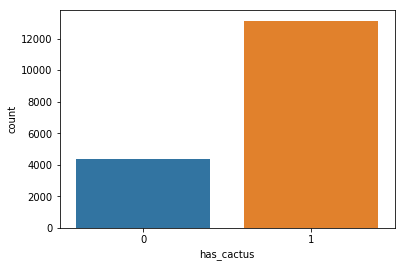

In [5]:
sns.countplot(train['has_cactus'])

**Note**: It's an imbalanced dataset. Later we will also learn how to handle imbalance in dataset.

It's always a good idea to keep all your hyperparameters and variables at the sampe place. It always come handy.

In [6]:
# train_validation split
training_data_percent = 0.85
len_df=len(train.id)
TRAINING_SAMPLE=int(len_df*training_data_percent)
VALIDATION_SAMPLE = int(len_df-TRAINING_SAMPLE)

print(f'The no. of training samples are {TRAINING_SAMPLE} and we are taking {training_data_percent * 100}% data as training\n Validation samples: {VALIDATION_SAMPLE} ')

The no. of training samples are 14875 and we are taking 85.0% data as training
 Validation samples: 2625 


In [7]:
# FILE_PATH
TRAIN_DIR = "../input/aerial-cactus-identification/train/train/"
TEST_DIR = "../input/aerial-cactus-identification/test/test"
WEIGHT_FILE = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# GENERAL
DROPOUT_RATE      = 0.4
NB_CLASSES        = 2

# LEARNING
BATCH_SIZE        = 128
NB_EPOCHS_BOTTLENECK = 5
NB_EPOCHS_FINETUNING = 5

# Global settings
model = "VGG16"
WIDTH, HEIGHT = 331,331
FC_LAYERS = [1024]

Handle imbalance of the dataset by calculating class weight for each class and pass it while calling **model.fit**.
Class with less number of samples are assighned higher weights.

In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train['has_cactus']),
                                                 train['has_cactus'])

print(f'The class weight of class0 i.e No cactus is {class_weights[0]} and \nClass weight of class1 i.e Has cactus is {class_weights[1]}')

The class weight of class0 i.e No cactus is 2.0050412465627865 and 
Class weight of class1 i.e Has cactus is 0.6661084043848965


**Plot a batch of training data**

In [9]:
# This function prepares a random batch from the dataset
def load_batch(dataset_df, batch_size = 25):
    batch_df = dataset_df.loc[np.random.permutation(np.arange(0,
                                                              len(dataset_df)))[:batch_size],:]
    return batch_df

# This function plots sample images in specified size and in defined grid
def plot_batch(images_df, grid_width, grid_height, im_scale_x, im_scale_y):
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(12, 12)

    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            ax[i][j].axis('off')
            ax[i][j].set_title(images_df.iloc[img_idx]['has_cactus'])
            ax[i][j].imshow(Image.open(TRAIN_DIR + images_df.iloc[img_idx]['id']).resize
                                             ((im_scale_x,im_scale_y)))
            img_idx += 1
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

In [10]:
batch_df = load_batch(train, 
                    batch_size=36)

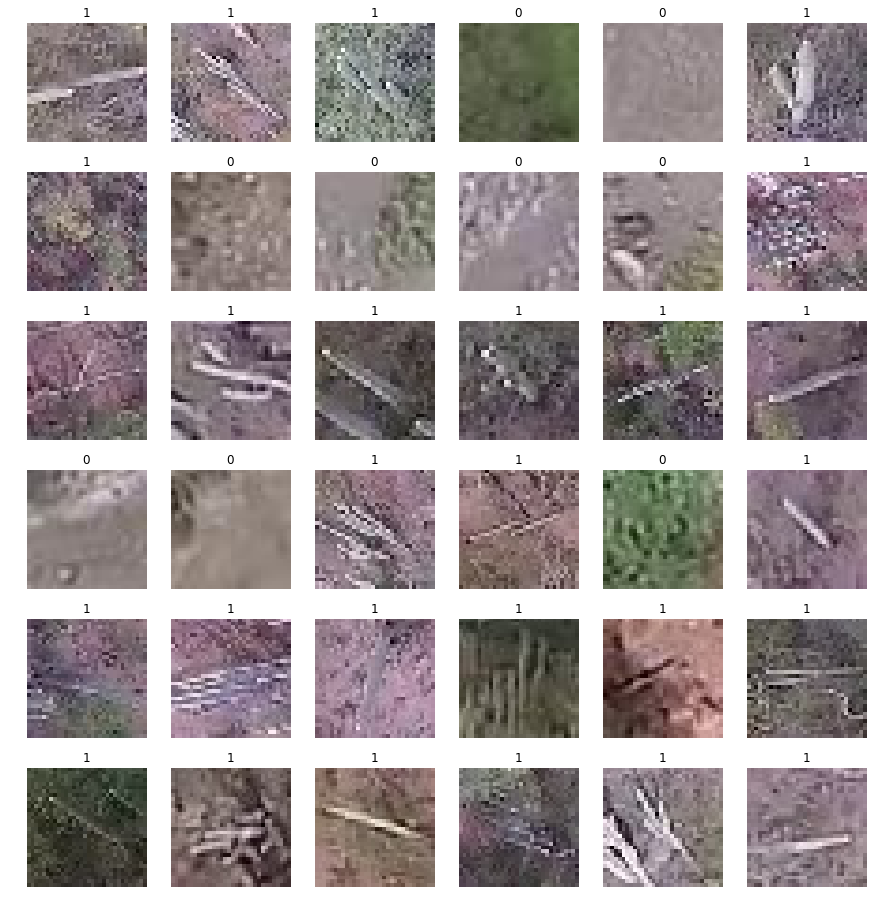

In [11]:
plot_batch(batch_df, grid_width=6, grid_height=6
           ,im_scale_x=64, im_scale_y=64)

# Preprocessing and Augmenting the Datasets

Data preparation is almost always required when working with any data analysis, machine learning, neural network or deep learning models. It becomes even more important to augment data in the case of image recognition. 

Keras provides the [ImageDataGenerator](https://keras.io/preprocessing/image/) class that defines the configuration for image data preparation and augmentation. It defines the arguments of the ImageDataGenerator class as follows:

**rotation_range** is a value in degrees (0-180), a range within which to randomly rotate pictures

**width_shift and height_shift** are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally

**rescale** is a value by which the data is multiplied before any other processing. The original images consist of RGB coefficients in the 0-255, but such values would be too high for the models to process (given a typical learning rate), values are targeted between 0 and 1 instead by scaling with a 1/255. factor.

**shear_range** is for randomly applying shearing transformations

**zoom_range** is for randomly zooming inside pictures
horizontal_flip is for randomly flipping half of the images horizontally, relevant when there are no assumptions of horizontal assymetric.

**Iterating through the dataset**

When training deep neural networks, we sometimes must load and preprocess the data while simultaneously training as the whole size of the dataset exceeds available RAM size, we can’t load it in advance and also to make models robust to things like translations, rotations we introduce randomness into the training process.

Depending on the data at hand we have to use keras data generators or sometimes write our own custom image datagenerator.

Here we will use keras data generator called **[flow_from_dataframe](https://keras.io/preprocessing/image/)**.

Typical input image sizes are `224×224, 227×227, 256×256, and 299×299. VGG16, VGG19` accept `224×224` input images while Inception V3 and Xception require `299×299` pixel inputs.

In [12]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(dataframe=train[:TRAINING_SAMPLE],directory=TRAIN_DIR,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=BATCH_SIZE,
                                            target_size=(WIDTH,HEIGHT))


validation_generator= val_datagen.flow_from_dataframe(dataframe=train[TRAINING_SAMPLE-1:len_df],directory=TRAIN_DIR,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=BATCH_SIZE,
                                                target_size=(WIDTH,HEIGHT))

Found 14875 validated image filenames belonging to 2 classes.
Found 2626 validated image filenames belonging to 2 classes.


# Transfer Learning

**Transfer learning** allows us to deal with this scenario by leveraging the data of some related task or domain, known as the source task and source domain. We store the knowledge gained in solving the source task in the source domain and apply it to the target task and target domain.

![](https://i.pinimg.com/originals/f8/cd/57/f8cd5798972afd87c469b2372ef70395.png)

**VGGNET**

VGGNet, scored second place in the ILSVRC and influenced the deep learning scene in an important way, as they showed that using a deeper architecture does generally lead to better results, which was not obvious at that time.

![](https://raw.githubusercontent.com/theainerd/MLInterview/master/Deep%20Learning/images/Screenshot%20from%202018-09-30%2009-45-48.png)

> Check refrences for more details on tranfer learning and more pretrained models


**Create base model**

In [13]:
# Prepare the model
if model == "VGG16":
    from keras.applications.vgg16 import preprocess_input
    preprocessing_function = preprocess_input
    base_model = VGG16(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "VGG19":
    from keras.applications.vgg19 import preprocess_input
    preprocessing_function = preprocess_input
    base_model = VGG19(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "ResNet50":
    from keras.applications.resnet50 import preprocess_input
    preprocessing_function = preprocess_input
    base_model = ResNet50(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "InceptionV3":
    from keras.applications.inception_v3 import preprocess_input
    preprocessing_function = preprocess_input
    base_model = InceptionV3(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "Xception":
    from keras.applications.xception import preprocess_input
    preprocessing_function = preprocess_input
    base_model = Xception(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "InceptionResNetV2":
    from keras.applications.inceptionresnetv2 import preprocess_input
    preprocessing_function = preprocess_input
    base_model = InceptionResNetV2(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "MobileNet":
    from keras.applications.mobilenet import preprocess_input
    preprocessing_function = preprocess_input
    base_model = MobileNet(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "DenseNet121":
    from keras.applications.densenet import preprocess_input
    preprocessing_function = preprocess_input
    base_model = DenseNet121(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "DenseNet169":
    from keras.applications.densenet import preprocess_input
    preprocessing_function = preprocess_input
    base_model = DenseNet169(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "DenseNet201":
    from keras.applications.densenet import preprocess_input
    preprocessing_function = preprocess_input
    base_model = DenseNet201(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
elif model == "NASNetLarge":
    from keras.applications.nasnet import preprocess_input
    preprocessing_function = preprocess_input
    base_model = NASNetLarge(weights = WEIGHT_FILE, include_top=True, input_shape=(HEIGHT, WIDTH, 3))
elif model == "NASNetMobile":
    from keras.applications.nasnet import preprocess_input
    preprocessing_function = preprocess_input
    base_model = NASNetMobile(weights = WEIGHT_FILE, include_top=False, input_shape=(HEIGHT, WIDTH, 3))
else:
    ValueError("The model you requested is not supported in Keras")
    


# Bottleneck Model

The top layer of the pre-trained model was removed and replaced with a new fully connected layer with a **Sigmoid classifier**. 

**GlobalAveragePooling2D** progressively reduces the spatial size and the amount of parameters and computation in the network as well as control overfitting. The [Dense](https://keras.io/layers/core/#dense) layer is the densely-connected Neural Network layer of size 1024 with the [Rectified Linear Unit](http://cs231n.github.io/neural-networks-1/) (relu) as the activator.


In [14]:
# Add on new FC layers with dropout for intializing the final fully connected layer

def build_bottleneck_model(base_model, dropout, fc_layers, num_classes):
    # Freeze All Layers Except Bottleneck Layers for Fine-Tuning
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) # New FC layer, random init
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes-1, activation='sigmoid')(x)
    
    bottleneck_model = Model(inputs=base_model.input, outputs=predictions)

    return bottleneck_model

# FineTuning Model

In the Fine Tuning phase some or none of the lower convolutional layers of the model were prevented from training depending upon the results from the Transfer Learning phase.

**Step 1 - Set up fine tuning on pre-trained ImageNet vgg16 model**

In finetuning model, we would input the model weights learned from `bottleneck_model` using

```python
from keras.models import Model
base_model = Model.load_weights(file_path_of_the_weights_file)

# Freeze Half of all Layers Except final Eight layers of VGG_NET Fine-Tuning
for layer in base_model.layers[:8]:
    layer.trainable = False
for layer in base_model.layers[:8]:
    layer.trainable = False
    
```
**Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9**

keep in mind that the **learning rate of optimizer low**. Rest it's all the same as bottleneck_model.
Usually this works fine for me.

```python
from keras.optimizers import SGD
optimizer=SGD(lr=0.0001, momentum=0.9)
```

For fine tuning you have to freeze different number of layers based on the architecture you are using. 

In [15]:
# Add on new FC layers with dropout for fine tuning

def build_finetuning_model(base_model, dropout, fc_layers, num_classes):

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) # New FC layer, random init
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes-1, activation='sigmoid')(x)
    
    finetuning_model = Model(inputs=base_model.input, outputs=predictions)

    return finetuning_model

# Model Building

**Bottleneck Model**

In [16]:
bottleneck_model = build_bottleneck_model(base_model, DROPOUT_RATE, FC_LAYERS, NB_CLASSES)
adam = Adam(lr=0.001)
bottleneck_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    
def lr_decay(epoch):
    if epoch%3 == 0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr/2)
        print("LR changed to {}".format(lr/2))
    return K.get_value(model.optimizer.lr)

learning_rate_schedule = LearningRateScheduler(lr_decay)

early_stopping = EarlyStopping(patience=2)

filepath= "../working/" + "weightfile.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint,early_stopping]


history = bottleneck_model.fit_generator(train_generator, epochs=NB_EPOCHS_BOTTLENECK, workers=8, steps_per_epoch= TRAINING_SAMPLE // BATCH_SIZE, 
validation_data=validation_generator, validation_steps= VALIDATION_SAMPLE // BATCH_SIZE, class_weight=class_weights, shuffle=True, callbacks=callbacks_list)

Epoch 1/5
116/116 [==============================] - 316s 3s/step - loss: 0.3123 - acc: 0.8585 - val_loss: 0.2492 - val_acc: 0.9027

Epoch 00001: val_loss improved from inf to 0.24924, saving model to ../working/weightfile.h5
Epoch 2/5
116/116 [==============================] - 287s 2s/step - loss: 0.2276 - acc: 0.8942 - val_loss: 0.2350 - val_acc: 0.9039

Epoch 00002: val_loss improved from 0.24924 to 0.23496, saving model to ../working/weightfile.h5
Epoch 3/5
116/116 [==============================] - 289s 2s/step - loss: 0.2120 - acc: 0.9027 - val_loss: 0.2128 - val_acc: 0.9135

Epoch 00003: val_loss improved from 0.23496 to 0.21275, saving model to ../working/weightfile.h5
Epoch 4/5
116/116 [==============================] - 288s 2s/step - loss: 0.1944 - acc: 0.9123 - val_loss: 0.1882 - val_acc: 0.9207

Epoch 00004: val_loss improved from 0.21275 to 0.18821, saving model to ../working/weightfile.h5
Epoch 5/5
116/116 [==============================] - 283s 2s/step - loss: 0.1827 - a

Cool, we achieved an accuracy of >92% and let's see fine tuning helps or not.

**Plot model accuracy and loss**

In [17]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

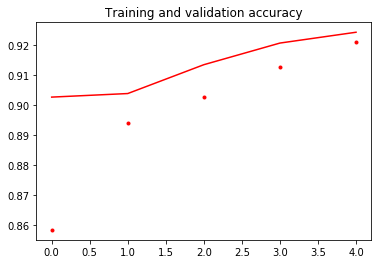

In [18]:
plot_training(history)

**FineTuning Model**

In [19]:
weights_file_path = '../working/weightfile.h5'

In [20]:
finetuning_model = build_finetuning_model(base_model, DROPOUT_RATE, FC_LAYERS, NB_CLASSES)
finetuning_model.load_weights(weights_file_path)
finetuning_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Freeze Half of all Layers Except final Eight layers of VGG_NET Fine-Tuning
for layer in finetuning_model.layers[:8]:
    layer.trainable = False
for layer in finetuning_model.layers[8:]:
    layer.trainable = True
    
    
optimizer=SGD(lr=0.001, momentum=0.9)    
def lr_decay(epoch):
    if epoch%3 == 0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr/2)
        print("LR changed to {}".format(lr/2))
    return K.get_value(model.optimizer.lr)

# learning_rate_schedule = LearningRateScheduler(lr_decay)

early_stopping = EarlyStopping(patience=2)

filepath= "../working/" + "_weightfile_finetuning.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint,early_stopping]


history_finetuning = bottleneck_model.fit_generator(train_generator, epochs=NB_EPOCHS_FINETUNING, workers=8, steps_per_epoch= TRAINING_SAMPLE // BATCH_SIZE, 
validation_data=validation_generator, validation_steps= VALIDATION_SAMPLE // BATCH_SIZE, class_weight=class_weights, shuffle=True, callbacks=callbacks_list)

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/5
116/116 [==============================] - 305s 3s/step - loss: 0.1801 - acc: 0.9209 - val_loss: 0.1822 - val_acc: 0.9235

Epoch 00001: val_loss improved from inf to 0.18222, saving model to ../working/_weightfile_finetuning.h5
Epoch 2/5
116/116 [==============================] - 280s 2s/step - loss: 0.1698 - acc: 0.9244 - val_loss: 0.2034 - val_acc: 0.9119

Epoch 00002: val_loss did not improve from 0.18222
Epoch 3/5
116/116 [==============================] - 287s 2s/step - loss: 0.1617 - acc: 0.9284 - val_loss: 0.1639 - val_acc: 0.9319

Epoch 00003: val_loss improved from 0.18222 to 0.16392, saving model to ../working/_weightfile_finetuning.h5
Epoch 4/5
116/116 [==============================] - 283s 2s/step - loss: 0.1542 - acc: 0.9330 - val_loss: 0.1598 - val_acc: 0.9303

Epoch 00004: val_loss improved from 0.16392 to 0.15984, saving model to ../working/_weightfile_finetuning.h5
Epoch 5/5
116/116 [==============================] - 290s 3s/step - loss: 0.1512 - acc: 0.9349

Usually depending on the problem you will get an improvment of 2-5% of improvment from bottleneck model.

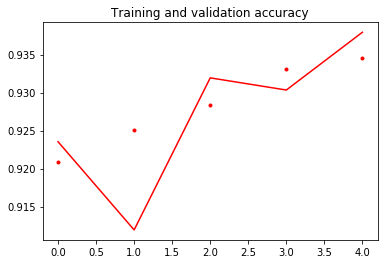

In [21]:
plot_training(history_finetuning)

# Some Key Ideas

* Always run your model on small data and try to overfit it. That way you can save ton of time and experiment a lot.
* If you are facing some problem don't give up. This guide [Troubleshooting Deep Neural Network](http://josh-tobin.com/assets/pdf/troubleshooting-deep-neural-networks-01-19.pdf) will surely come handy.

# Refrences

[A Non-Technical Survey on Deep Convolutional Neural Network Architectures](https://arxiv.org/pdf/1803.02129.pdf)

[CS231n: Convolutional Neural Networks for Visual Recognition Spring 2018](http://cs231n.stanford.edu/2018/)

[Keras Applications](https://keras.io/applications/) : Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

[Tutorial on Keras flow_from_dataframe](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

**Some library worth exploring**

[Albumentations](https://github.com/albu/albumentations): Fast image augmentation library

[CBAM-keras](https://github.com/kobiso/CBAM-keras) Convolutional Block Attention Module to improve representation power by using attention mechanism: focusing on important features and supressing unnecessary ones.







<center><span style="color:red">**If you liked this kernel do upvote and also share with people who could learn something new with this. Happy Learning **</span></centre> 
<img src="https://external-preview.redd.it/I3Z3MHAmKZ2dbH6TmHgEltNICo2xLScHVZnmprDUvc4.png?auto=webp&s=1498ffe4d22f902f2d47f05dd91ec135c9eb2061" width=200,height=300>